# cluster correlation study
idea: 
1. for each atc level 3 code, cluster the people into groups based on their drug use sequences on this drug category
2. see if there is a pattern that: people in the same cluster have similar drug use patterns on other drug categories. e.g. people in the same group in N06A cluster tend to be in the same group in N05A cluster.
3. if such a pattern exists for some atc level 3 codes, e.g. N05A and N06A, we say these two atc level 3 codes are correlated, and we can calculate the correlation score between them.
4. we can use this pattern to predict the cluster of a new patient in this drug category.


In [22]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from project_permed.sequence import from_eid_df, cluster
from tqdm import tqdm

In [3]:
df = pd.read_csv("../../dataset/df_cleaned_1atc.tsv", sep="\t")
df["drug_era_start_date"] = pd.to_datetime(df["drug_era_start_date"])
df["drug_era_end_date"] = pd.to_datetime(df["drug_era_end_date"])

In [4]:
# create a small df of 10k eids
eids = random.choices(df["eid"].unique(), k=10000)
df_small = df[df["eid"].isin(eids)]

In [5]:
print(
    f"number of unique ATC level 3 codes in small_df: {len(df_small['atc_level3'].unique())}"
)

number of unique ATC level 3 codes in small_df: 95


In [6]:
atc_lv3_dfs = {}
for atc_lv3 in df_small["atc_level3"].unique():
    atc_lv3_df = (
        df_small[df_small["atc_level3"] == atc_lv3]
        .sort_values(by=["eid", "drug_era_start_date"])
        .reset_index(drop=True)
    )
    # label each drug with a unique number
    atc_code_to_num = {
        atc_code: i + 1 for i, atc_code in enumerate(atc_lv3_df["atc_code"].unique())
    }
    atc_lv3_df["atc_code_num"] = atc_lv3_df["atc_code"].map(atc_code_to_num)
    atc_lv3_dfs[atc_lv3] = atc_lv3_df

upper and lower 25% quantiles: [ 315. 1935.]
number of unique ATC level 3 codes in filtered dfs: 47


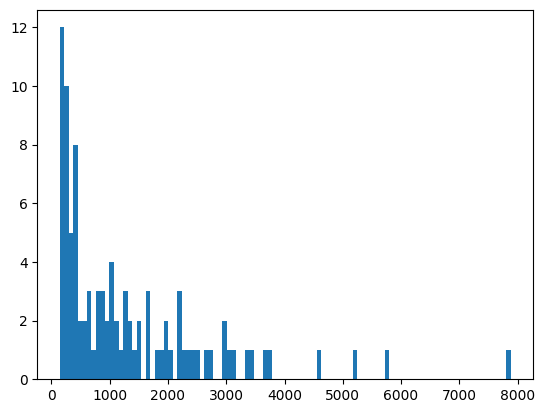

In [7]:
# find some statistics of the population in each ATC level 3 code
population_stats = {}
for atc_lv3, df_atc_lv3 in atc_lv3_dfs.items():
    population_stats[atc_lv3] = df_atc_lv3["eid"].nunique()

# plot the population distribution and find the upper and lower 15% quantiles
plt.hist(list(population_stats.values()), bins=100)
q_values = np.quantile(list(population_stats.values()), [0.25, 0.75])
print(f"upper and lower 25% quantiles: {q_values}")

# filter out the ATC level 3 codes with population outside the upper and lower 25% quantiles
atc_lv3_dfs_filtered = {
    atc_lv3: df_atc_lv3
    for atc_lv3, df_atc_lv3 in atc_lv3_dfs.items()
    if population_stats[atc_lv3] > q_values[0]
    and population_stats[atc_lv3] < q_values[1]
}

# find the number of unique ATC level 3 codes in the filtered df
print(
    f"number of unique ATC level 3 codes in filtered dfs: {len(atc_lv3_dfs_filtered.keys())}"
)

In [16]:
# for each filtered ATC level 3 code, cluster the sequences and find the linkage matrix
linkage_matrices = {}
clusters = {}
eid_mapping = {}
for atc_lv3, df_atc_lv3 in tqdm(atc_lv3_dfs_filtered.items()):
    eids = df_atc_lv3["eid"].unique()
    sequences = [from_eid_df(df_atc_lv3[df_atc_lv3["eid"] == eid]) for eid in eids]
    clusters[atc_lv3], linkage_matrices[atc_lv3] = cluster(sequences)
    eid_mapping[atc_lv3] = {eid: i for i, eid in enumerate(eids)}

100%|██████████| 47/47 [03:05<00:00,  3.95s/it]


In [32]:
# create a new dataframe with each row representing the cluster for each ATC level 3 code for each eid
rows = []
all_atc_lv3s = list(atc_lv3_dfs_filtered.keys())
for eid in df_small["eid"].unique():
    atc_groups = {
        atc_lv3: clusters[atc_lv3][eid_mapping[atc_lv3].get(eid, 0)]
        for atc_lv3 in all_atc_lv3s
    }
    rows.append({"eid": eid, **atc_groups})
df_clusters = pd.DataFrame(rows)
# set eid to be the index
df_clusters = df_clusters.set_index("eid")

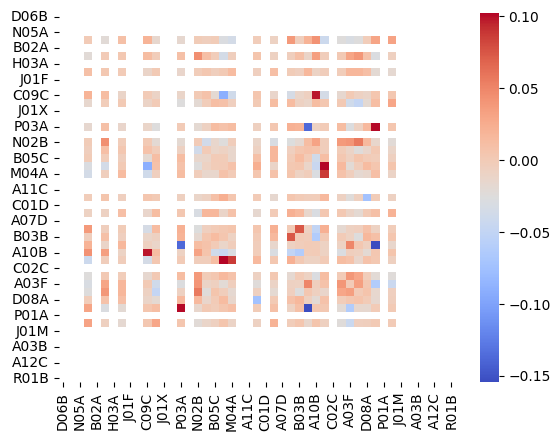

In [34]:
# create a correlation matrix between the clusters
correlation_matrix = df_clusters.corr()

# replace all the values of 1 with None
correlation_matrix = correlation_matrix.replace(1, 0)

# visualize the correlation matrix using seaborn
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()